In [3]:
# Aidan FERNANDEZ & Youssef GUIZA
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import bisect


import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessioKn

In [4]:
# Read in the data
df_train = pd.read_csv('train.csv')
X_train = df_train.drop(['Survived'],axis=1)
X_test = pd.read_csv('test.csv')
y_train = df_train[["Survived"]]
y_test = pd.read_csv('gender_submission.csv')

X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
X_train.shape

(891, 11)

In [7]:
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [8]:
X_train.isna().sum(axis=0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
X_train = X_train.drop(['Cabin'],axis = 1)
X_test = X_test.drop(['Cabin'],axis = 1)

num_col = ["Age","Fare"]
cat_col = ["Embarked"]

imp_median = SimpleImputer(strategy='median')
X_train[num_col] = imp_median.fit_transform(X_train[num_col])
X_test[num_col] = imp_median.transform(X_test[num_col])

imp_most_frequent = SimpleImputer(strategy='most_frequent')
X_train[cat_col] = imp_most_frequent.fit_transform(X_train[cat_col])
X_test[cat_col] = imp_most_frequent.transform(X_test[cat_col])

y_train = y_train.loc[X_train.index]
X_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
413,1305,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.0500,S
417,1309,3,"Peter, Master. Michael J",male,28.0,1,1,2668,22.3583,C


In [10]:
X_test.isna().sum(axis = 0)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [11]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [12]:
X_train['Title'] = X_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_test['Title'] = X_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

X_train['Title'].value_counts()


Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [13]:
X_test['Title'].value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [14]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

X_train['Title'] = X_train['Title'].map(title_mapping)
X_test['Title'] = X_test['Title'].map(title_mapping)
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [15]:
X_train.drop('Name', axis=1, inplace=True)
X_test.drop('Name', axis=1, inplace=True)

In [16]:
X_train.loc[X_train['Age'] <= 16, 'Age'] = 0
X_train.loc[(X_train['Age'] > 16) & (X_train['Age'] <= 26), 'Age'] = 1
X_train.loc[(X_train['Age'] > 26) & (X_train['Age'] <= 36), 'Age'] = 2
X_train.loc[(X_train['Age'] > 36) & (X_train['Age'] <= 62), 'Age'] = 3
X_train.loc[X_train['Age'] > 62, 'Age'] = 4

X_test.loc[X_test['Age'] <= 16, 'Age'] = 0
X_test.loc[(X_test['Age'] > 16) & (X_test['Age'] <= 26), 'Age'] = 1
X_test.loc[(X_test['Age'] > 26) & (X_test['Age'] <= 36), 'Age'] = 2
X_test.loc[(X_test['Age'] > 36) & (X_test['Age'] <= 62), 'Age'] = 3
X_test.loc[X_test['Age'] > 62, 'Age'] = 4


In [17]:
Pclass1 = X_train[X_train['Pclass'] == 1]['Embarked'].value_counts()
Pclass2 = X_train[X_train['Pclass'] == 2]['Embarked'].value_counts()
Pclass3 = X_train[X_train['Pclass'] == 3]['Embarked'].value_counts()
print("Pclass1:\n",Pclass1)
print("Pclass2:\n",Pclass2)
print("Pclass3:\n",Pclass3)

Pclass1:
 Embarked
S    129
C     85
Q      2
Name: count, dtype: int64
Pclass2:
 Embarked
S    164
C     17
Q      3
Name: count, dtype: int64
Pclass3:
 Embarked
S    353
Q     72
C     66
Name: count, dtype: int64


In [18]:
embarked_mapping = {'S':0,'C':1,'Q':2}
X_train['Embarked'] = X_train['Embarked'].map(embarked_mapping)
X_test['Embarked'] = X_test['Embarked'].map(embarked_mapping)

In [19]:
X_train.loc[X_train['Fare'] <= 17, 'Fare'] = 0
X_train.loc[(X_train['Fare'] > 17) & (X_train['Fare'] <= 30), 'Fare'] = 1
X_train.loc[(X_train['Fare'] > 30) & (X_train['Fare'] <= 100), 'Fare'] = 2
X_train.loc[X_train['Fare'] >= 100, 'Fare'] = 3

X_test.loc[X_test['Fare'] <= 17, 'Fare'] = 0
X_test.loc[(X_test['Fare'] > 17) & (X_test['Fare'] <= 30), 'Fare'] = 1
X_test.loc[(X_test['Fare'] > 30) & (X_test['Fare'] <= 100), 'Fare'] = 2
X_test.loc[X_test['Fare'] >= 100, 'Fare'] = 3

X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,3,male,1.0,1,0,A/5 21171,0.0,0,0
1,2,1,female,3.0,1,0,PC 17599,2.0,1,2
2,3,3,female,1.0,0,0,STON/O2. 3101282,0.0,0,1
3,4,1,female,2.0,1,0,113803,2.0,0,2
4,5,3,male,2.0,0,0,373450,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
886,887,2,male,2.0,0,0,211536,0.0,0,3
887,888,1,female,1.0,0,0,112053,1.0,0,1
888,889,3,female,2.0,1,2,W./C. 6607,1.0,0,1
889,890,1,male,1.0,0,0,111369,1.0,1,0


In [20]:
X_train["FamilySize"] = X_train["SibSp"] + X_train["Parch"] + 1
X_test["FamilySize"] = X_test["SibSp"] + X_test["Parch"] + 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
X_train['FamilySize'] = X_train['FamilySize'].map(family_mapping)
X_test['FamilySize'] = X_test['FamilySize'].map(family_mapping)

In [21]:
features_drop = ['Ticket','SibSp','Parch']
X_train = X_train.drop(features_drop, axis = 1)
X_test = X_test.drop(features_drop,axis=1)

<Axes: >

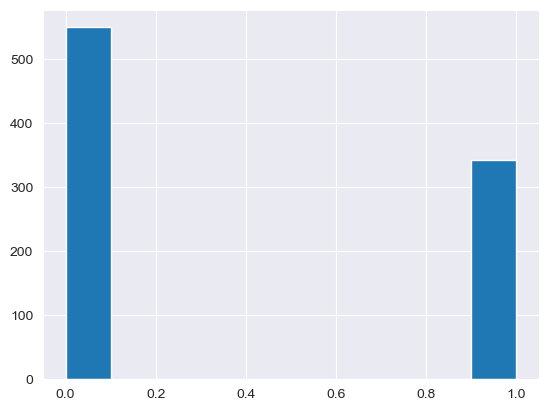

In [22]:
df_train['Survived'].hist()

<Figure size 640x480 with 0 Axes>

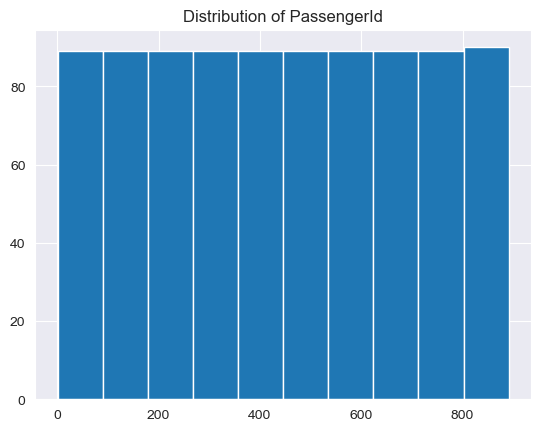

<Figure size 640x480 with 0 Axes>

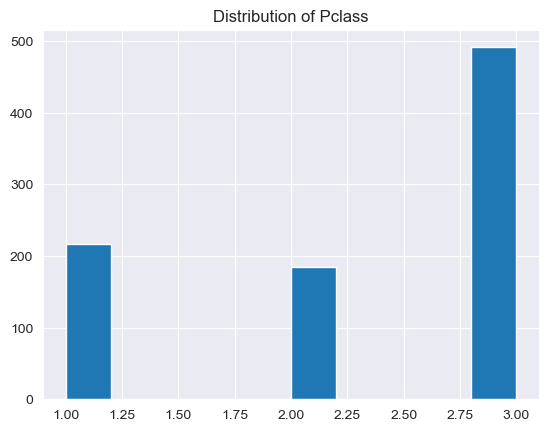

<Figure size 640x480 with 0 Axes>

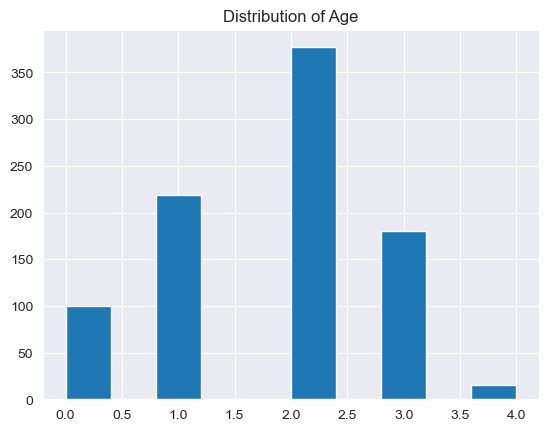

<Figure size 640x480 with 0 Axes>

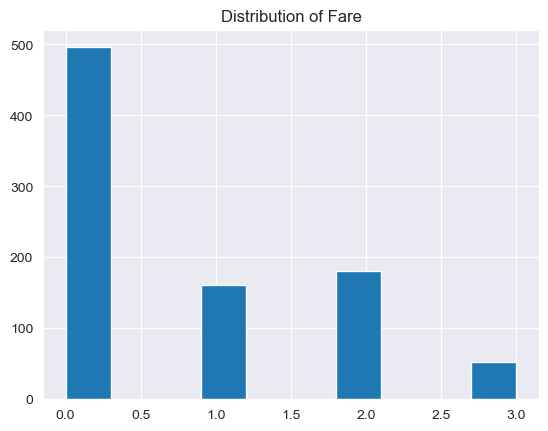

<Figure size 640x480 with 0 Axes>

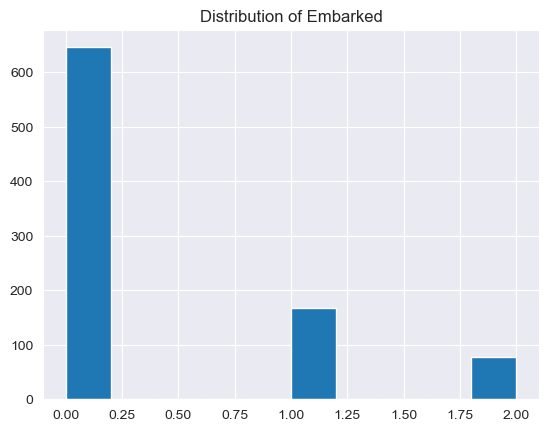

<Figure size 640x480 with 0 Axes>

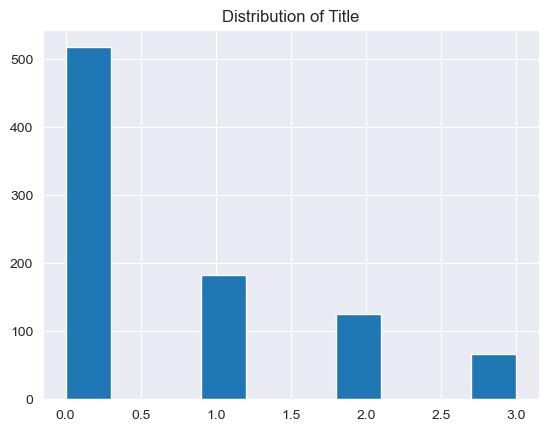

<Figure size 640x480 with 0 Axes>

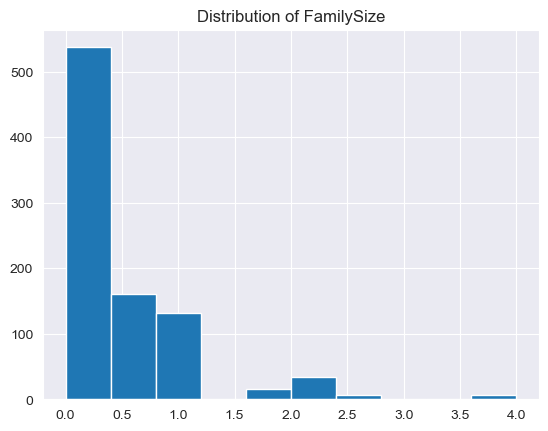

In [23]:
num = X_train.select_dtypes(include=[np.number]).columns.tolist()
for column in num:
    plt.figure()
    X_train.hist([column])
    plt.title(f'Distribution of {column}')

In [24]:
X_train

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,1,3,male,1.0,0.0,0,0,0.4
1,2,1,female,3.0,2.0,1,2,0.4
2,3,3,female,1.0,0.0,0,1,0.0
3,4,1,female,2.0,2.0,0,2,0.4
4,5,3,male,2.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...
886,887,2,male,2.0,0.0,0,3,0.0
887,888,1,female,1.0,1.0,0,1,0.0
888,889,3,female,2.0,1.0,0,1,1.2
889,890,1,male,1.0,1.0,1,0,0.0


<Axes: >

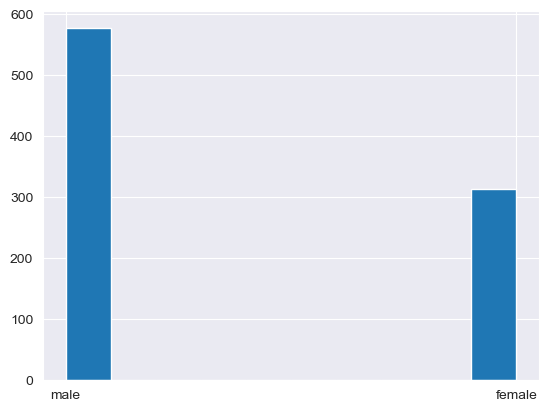

In [25]:
X_train['Sex'].hist()


In [26]:
X_test['PassengerId']

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

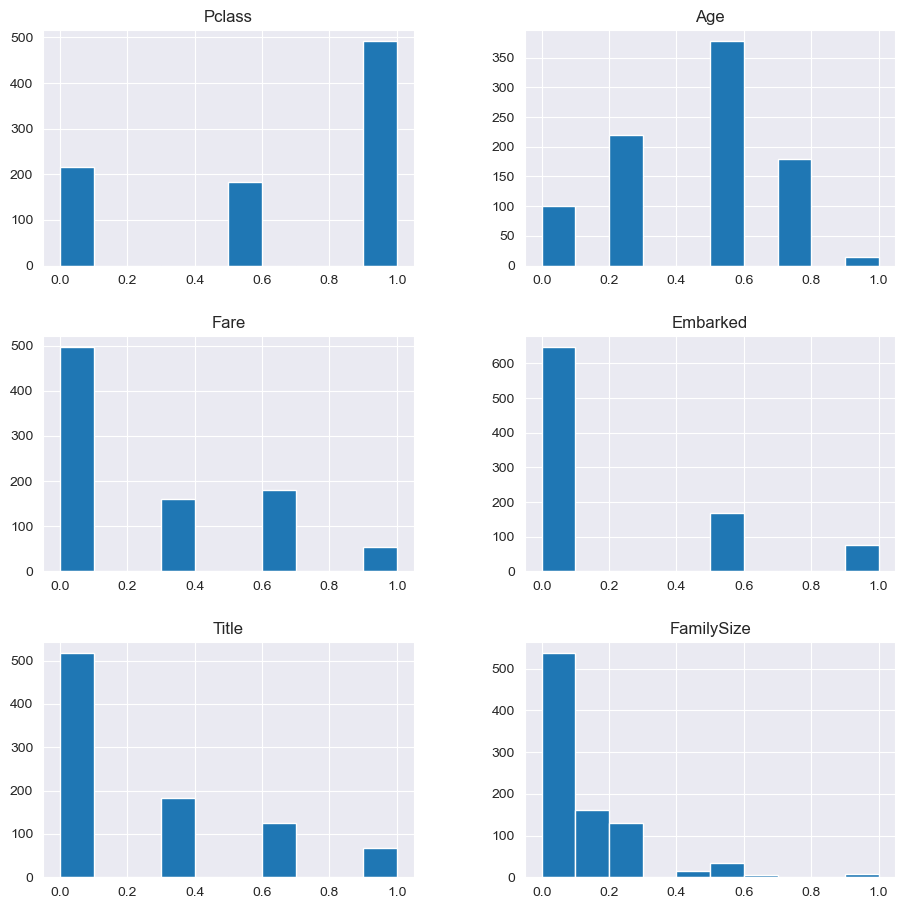

In [27]:
mmc = MinMaxScaler()

num.remove('PassengerId')
X_train[num] = mmc.fit_transform(X_train[num])
X_test[num] = mmc.transform(X_test[num])

X_train[num].hist(figsize=[11,11]);

In [28]:
le = LabelEncoder()
X_train['Sex'] = le.fit_transform(X_train['Sex'])
X_test['Sex'] = le.fit_transform(X_test['Sex'])
X_test.tail()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
413,1305,1.0,1,0.50,0.000000,0.0,0.0,0.0
414,1306,0.0,0,0.75,1.000000,0.5,1.0,0.0
415,1307,1.0,1,0.75,0.000000,0.0,0.0,0.0
416,1308,1.0,1,0.50,0.000000,0.0,0.0,0.0
417,1309,1.0,1,0.50,0.333333,0.5,1.0,0.2


In [29]:
random_grid = { 'n_estimators': [int(x) for x in np.linspace(start=50, stop=1000, num=20)],  # Change the range for n_estimators
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 200, num=20)] + [None],  # Change the range for max_depth
    'min_samples_split': [2, 5, 10, 15, 20],  # Adjust values for min_samples_split
    'min_samples_leaf': [1, 2, 4, 6, 8],  # Adjust values for min_samples_leaf
    'bootstrap': [True, False]}

print(random_grid)
rf = RandomForestClassifier(criterion="gini", random_state=0)
rf_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=0)
rf_search = rf_search.fit(X_train, y_train)

#Model Evalutation
Y_pred = rf_search.predict(X_test)

acc_random_forest = rf_search.score(X_train, y_train)
acc_random_forest

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, None], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


0.8787878787878788

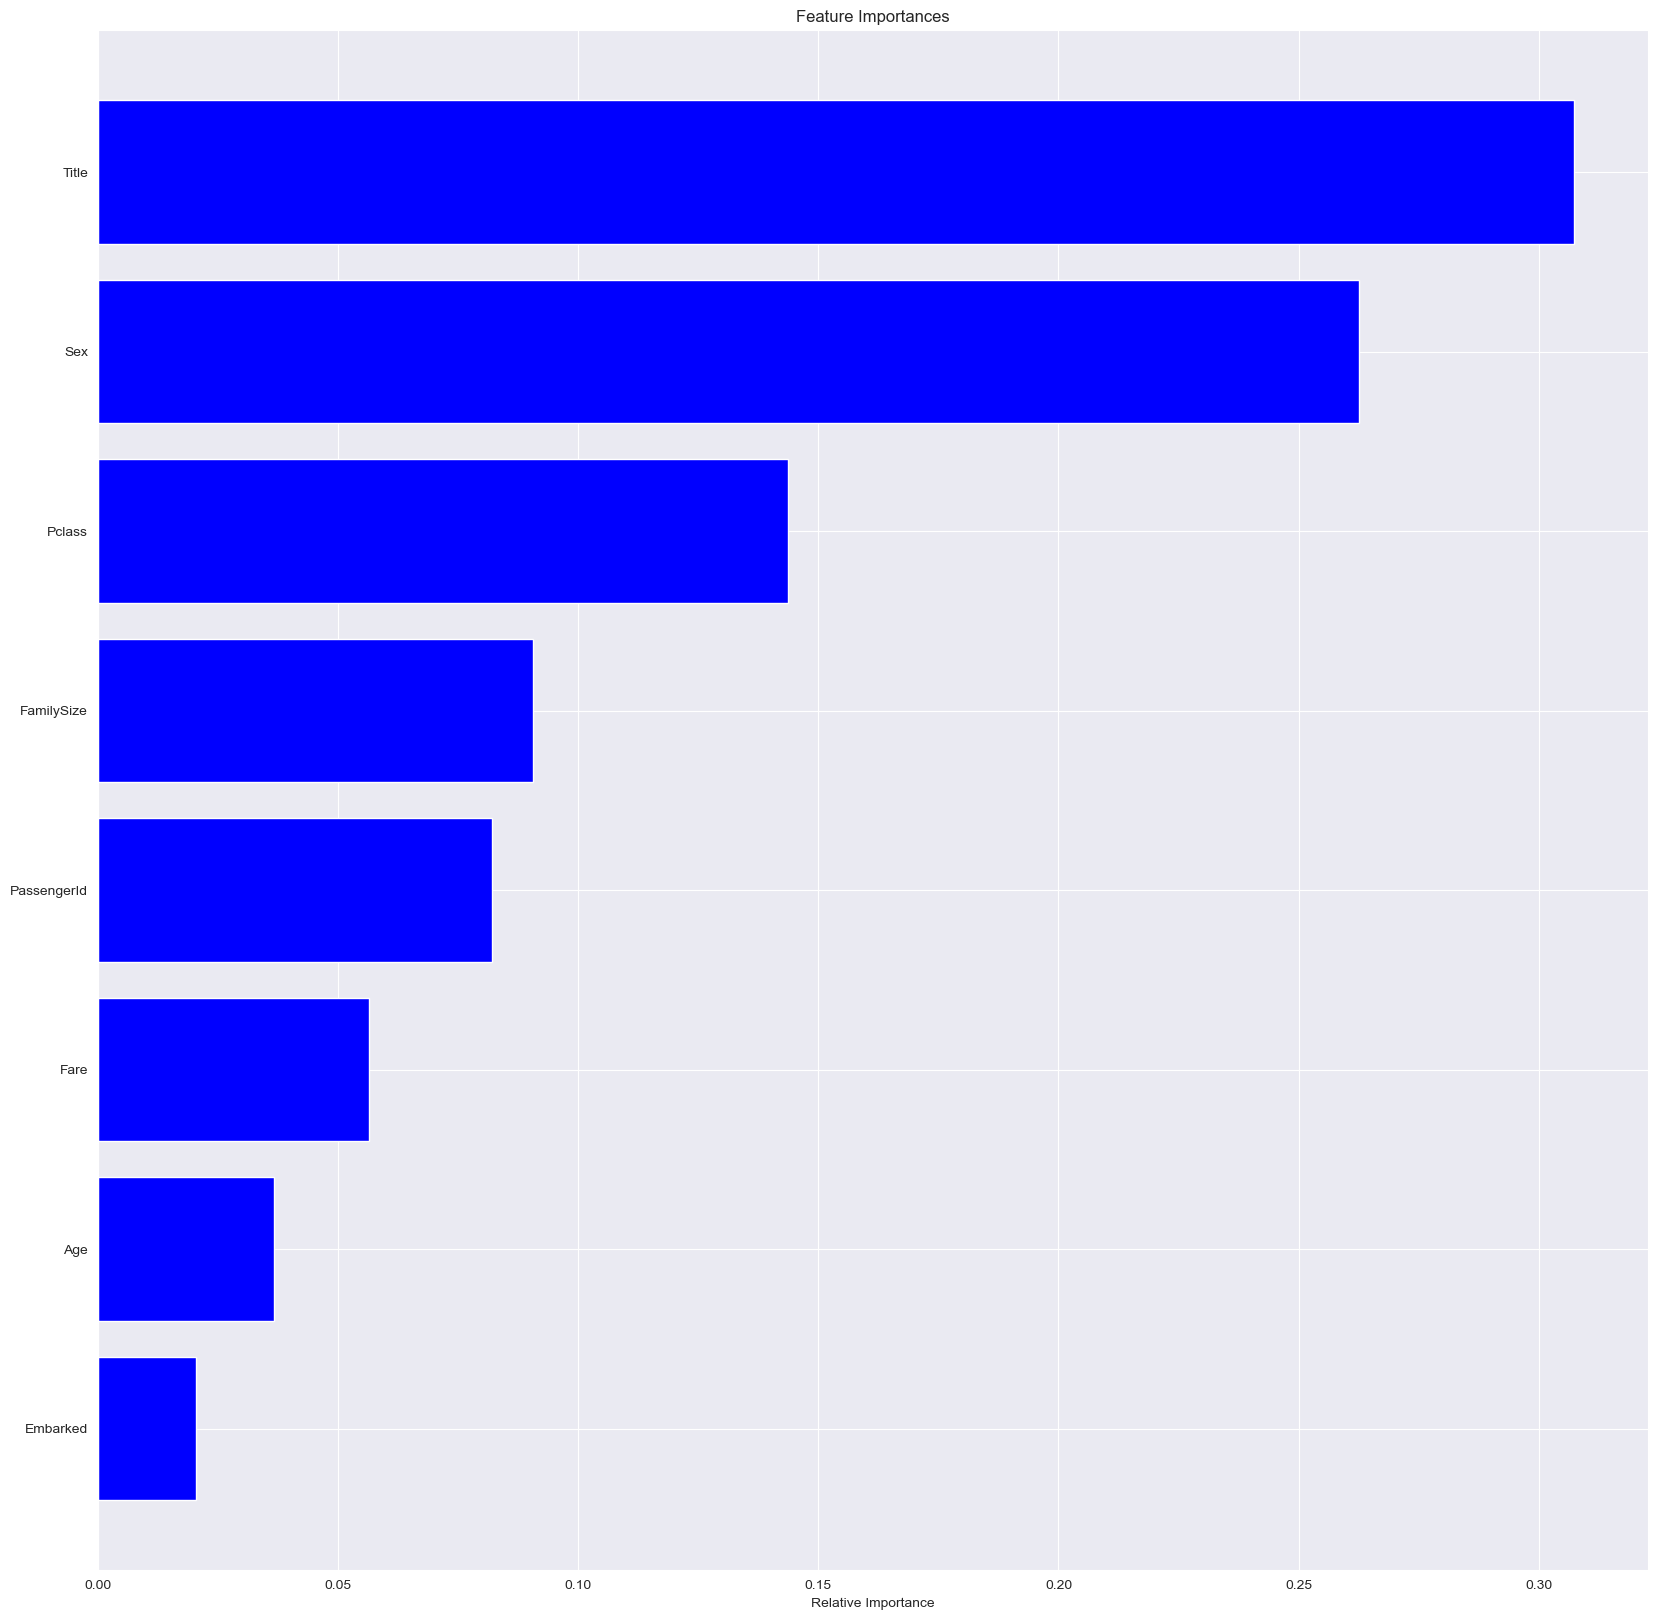

In [30]:
features = X_train.columns
importances = rf_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [31]:
X_test_reset = X_test.reset_index(drop=True) 
result = pd.concat([X_test_reset["PassengerId"], pd.DataFrame(Y_pred)], axis = 1, ignore_index=True)
result.columns = ["PassengerId","Survived"]
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [32]:
result.to_csv("/kaggle/working/result_rf.csv",index = False)

OSError: Cannot save file into a non-existent directory: '/kaggle/working'